In [2]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pandas_datareader

Note: you may need to restart the kernel to use updated packages.


In [7]:
import math 
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [8]:
#prikazi floatove normalno, a ne u scientific formatu
pd.options.display.float_format = '{:.2f}'.format

In [9]:
df0 = pd.read_excel('mergeBTCdtp_NN.xlsx',  header=0)

df0

,Row Labels,Count of Posts,Sum of Voted Score,BTC open value,BTC close value
0,2020-12-01 00:00:00,1,1.26,19695.87,19565.47
1,2020-12-01 01:00:00,2,0.73,19565.47,19605.75
2,2020-12-01 02:00:00,5,-0.10,19605.75,19680.95
3,2020-12-01 03:00:00,5,1.41,19680.96,19419.74
4,2020-12-01 04:00:00,4,2.73,19419.73,19354.31
...,...,...,...,...,...
2696,2021-04-30 21:00:00,3,0.93,56757.34,56976.53
2697,2021-04-30 22:00:00,4,3.78,56976.53,57119.75
2698,2021-04-30 23:00:00,3,0.24,57119.76,57694.27
2699,(blank),48,67.63,nan,nan


In [10]:
kolone = [ 'Row Labels', 'Sum of Voted Score', 'BTC close value']
df = df1[kolone]

# drop last 2 rows
df.drop(df.tail(2).index,inplace=True) 

#menjamo index 
df = df.set_index(pd.DatetimeIndex(df['Row Labels'].values))
del df['Row Labels']
df

NameError: name 'df1' is not defined

In [11]:
#pravimo novi df samo sa close kolonom
#data = df.filter(['Sum of Voted Score', 'BTC close value'])

#konvertujemo df u numpy array
dataset = df.values

#broj redova na kojem cemo trenirati model
# 86% jer fale neki podaci za april
training_data_len = math.ceil(len(dataset) * .86)
training_data_len 

NameError: name 'df' is not defined

<function matplotlib.pyplot.show(close=None, block=None)>

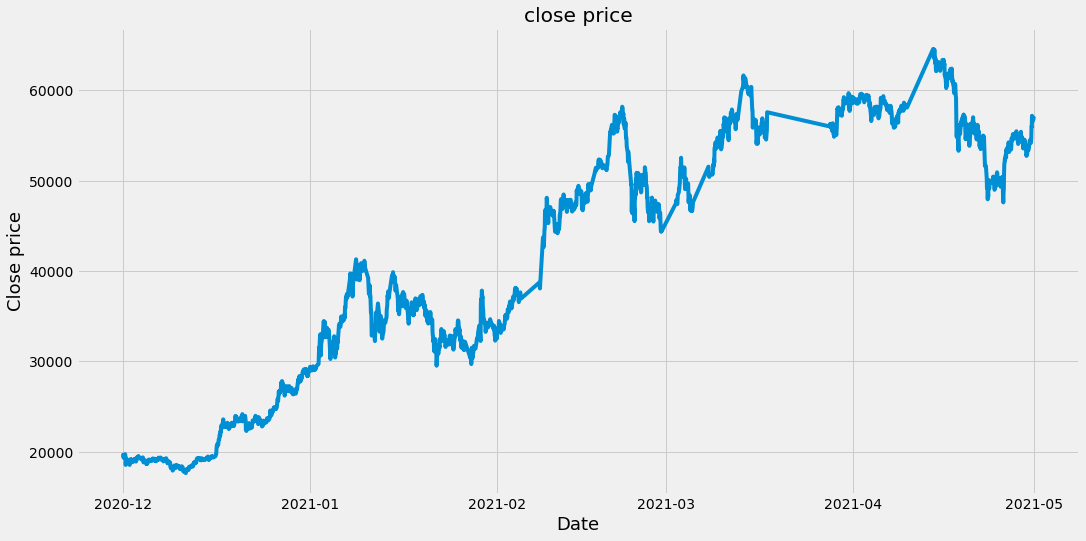

In [298]:
plt.figure(figsize=(16,8))
plt.title('close price')
plt.plot(df['BTC close value'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close price', fontsize=18)
plt.show

In [299]:
#skaliramo podatke (dobra praksa koja cesto olaksava treniranje NN)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.35346157, 0.04086466],
       [0.35325825, 0.04172297],
       [0.35293867, 0.04332537],
       ...,
       [0.35304742, 0.83336895],
       [0.35333464, 0.83803957],
       [0.35443156, 0.84109138]])

In [300]:
#pravimo data set za treniranje
#pravimo skaliran data set za treniranje
train_data = scaled_data[0:training_data_len, :]
#delimo podatke na x_train i y_train data set
x_train = []
y_train = []


for i in range(24, len(train_data)):
    x_train.append(train_data[i-24:i, 0:2])
    y_train.append(train_data[i, 1])
    if i<=25:
        print(x_train)
        print(y_train)
        print()
#type(train_data)
#train_data[i-24:i,0:2]

[array([[0.35346157, 0.04086466],
       [0.35325825, 0.04172297],
       [0.35293867, 0.04332537],
       [0.35352029, 0.03775936],
       [0.35402899, 0.03636515],
       [0.35370043, 0.0391229 ],
       [0.35395225, 0.03602485],
       [0.35851853, 0.03980264],
       [0.35317292, 0.03876619],
       [0.35308274, 0.04085464],
       [0.35666138, 0.0445732 ],
       [0.35297819, 0.03787145],
       [0.35363506, 0.01925525],
       [0.35229326, 0.02369552],
       [0.35254095, 0.03489486],
       [0.35400148, 0.03442735],
       [0.35348084, 0.03006826],
       [0.35297819, 0.03005974],
       [0.35460557, 0.02324996],
       [0.35303655, 0.03030244],
       [0.3532444 , 0.02933354],
       [0.3532297 , 0.02963335],
       [0.35275943, 0.02657792],
       [0.35069443, 0.02380696]])]
[0.025331587453960247]

[array([[0.35346157, 0.04086466],
       [0.35325825, 0.04172297],
       [0.35293867, 0.04332537],
       [0.35352029, 0.03775936],
       [0.35402899, 0.03636515],
       [0.35370

In [301]:
#Convert the x_train and y_Train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [302]:
#LSTM neuronska mreza prima 3d podatke (slucajeve, vreme, feature(atribute koje koristimo u predikciji, kod nas su to cena i sentiment))
#2D podatke prebacujemo u 3D
#np.reashape prima niz i novu strukturu
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 2))
x_train.shape

(2135, 24, 2)

In [303]:
# LSTM model
model=Sequential()

#dodajemo sloj od 50 neurona, vraca
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],2)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [304]:
#Kompajliranje modela
model.compile(optimizer='adam', loss='mean_squared_error')

In [305]:
#Treniranje modela
model.fit(x_train,y_train, batch_size=1, epochs=1)

2135/2135 [==============================] - 18s 7ms/step - loss: 0.0042


In [306]:
# pravimo test data set
# pravimo novi niz koji sadrzi skalirane vrednosti od dana 2160 do 2699
test_data = scaled_data[training_data_len - 24: , :]
#pravimo data setove x_test i y_test
x_test = []
y_test = dataset[training_data_len: , 1:2 ]

for i in range(24, len(test_data)):
    x_test.append(test_data[i-24:i, 0:2])
    
y_test

array([[58850.  ],
       [58670.64],
       [58739.13],
       [58816.21],
       [58950.01],
       [59387.13],
       [59254.98],
       [59408.2 ],
       [59221.53],
       [59394.92],
       [59466.37],
       [59410.96],
       [59298.85],
       [59028.65],
       [59423.9 ],
       [59338.14],
       [59255.02],
       [59254.76],
       [59414.8 ],
       [59144.38],
       [58829.99],
       [58809.74],
       [58210.13],
       [58455.36],
       [58597.04],
       [58054.15],
       [57631.28],
       [57556.75],
       [57051.94],
       [56600.  ],
       [56933.46],
       [57363.48],
       [57492.42],
       [57547.52],
       [57477.08],
       [57439.98],
       [57614.52],
       [57429.84],
       [57686.35],
       [57708.05],
       [57275.55],
       [58128.14],
       [58130.99],
       [57918.11],
       [58030.89],
       [58179.03],
       [58102.92],
       [57953.86],
       [58025.11],
       [58116.69],
       [58129.22],
       [58202.01],
       [5790

In [307]:
#konvertujemo podatke u np array kako bi mogli da ih koristimo u LSTM modelu
x_test = np.array(x_test)


In [308]:
#Reshape                     broj sekvenci,duzina sekvence(24),broj featura
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 2))


In [309]:
# root mean squared error (RMSE) 
rmse = np.sqrt(np.mean(predictions - y_test) **2)
rmse

1285.0872854823747

In [310]:
stvarni_i_predikcije = np.concatenate((y_test,predictions),axis=1)

#print(y_test[0,0])
#print(stvarni_i_predikcije[0,0])
max = 0

for i in range(0,len(y_test)):
    razlika = y_test[i,0] - predictions[i,0]
    if abs(razlika) > max:
        max = razlika
    if razlika > 3000:
        print(y_test[i],predictions[i],razlika)
    
#niz = np.concatenate((stvarni_i_predikcije,razlika),axis=1)
print(max)
#niz_razlika

[64577.26] [56908.336] 7668.924062500002
[64288.8] [57662.64] 6626.159374999996
[63928.57] [58632.664] 5295.9059375
[63568.42] [59574.465] 3993.9551562500055
[64099.99] [60336.9] 3763.091562499998
[64511.21] [60977.758] 3533.452187499999
[51920.39] [48285.855] 3634.534531249992
[51969.24] [48732.04] 3237.200937499998
[52398.99] [49254.977] 3144.013437499998
[57180.06] [53767.707] 3412.3529687499977
7668.924062500002


In [5]:
# podaci za graf
train = data[2100:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

# visualizacija
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Datum', fontsize=18)
plt.ylabel('Cena', fontsize=18)
plt.plot(train['BTC close value'])
plt.plot(valid[['BTC close value', 'Predictions']])
plt.legend(['Train','Stvarni','Predikcije'], loc='lower right')
plt.show()

NameError: name 'data' is not defined

In [312]:
valid

,Sum of Voted Score,BTC close value,Predictions
2021-04-02 19:00:00,0.20,58850.00,57791.77
2021-04-02 20:00:00,0.36,58670.64,57709.38
2021-04-02 21:00:00,-0.20,58739.13,57603.89
2021-04-02 22:00:00,3.23,58816.21,57511.32
2021-04-02 23:00:00,0.47,58950.01,57443.83
...,...,...,...
2021-04-30 18:00:00,1.88,56857.47,54850.48
2021-04-30 19:00:00,0.00,57007.38,55095.98
2021-04-30 20:00:00,0.18,56757.34,55304.30
2021-04-30 21:00:00,0.93,56976.53,55431.82
